# Introduction


After a novel strain of coronavirus, SARS-CoV-2, was identified in Wuhan (Hubei), China, an
exponentially growing number of patients in mainland China were diagnosed with COVID-19,
prompting Chinese authorities to introduce radical measures to contain the outbreak. Despite
these measures, a COVID-19 pandemic ensued in the following months. <br/>

Italy has been severely affected. After the first indigenous case on 21 February 2020 in Lodi
province, several suspect cases (initially epidemiologically linked) began to emerge in the south
and southwest territory of Lombardy.<br/>
The World Health Organization report dated 19 March 2021 reported 3,306,711 confirmed cases
and 103,855 deaths worldwide.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': 10, 'font.style': 'normal', 'font.family':'serif'})

In [5]:
df = pd.read_csv('data_provinces.csv').drop('Unnamed: 0', axis=1)
df.head()

,LO,PV,SO,MN,MI,CO,BS,MB,LC,CR,BG,VA
0,0,0,0,1,0,1,2,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0


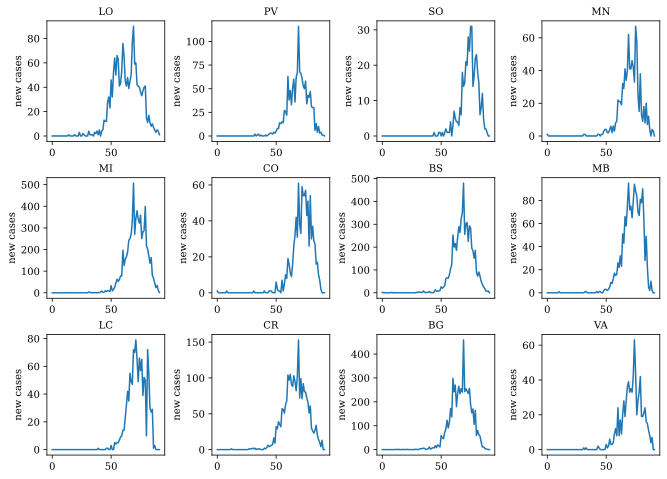

In [6]:
fig = plt.figure(figsize=(11, 8))
fig.subplots_adjust(hspace=0.3, wspace=0.4)
for i in range(len(df.columns)):
    ax = fig.add_subplot(3, 4, i+1, ylabel = 'new cases')
    ax.plot(df.iloc[:, i])
    plt.title(df.columns[i], size = 10)

In [7]:
regions = 'LO PV SO MN MI CO BS MB LC CR BG VA'.split(' ')
population = '44928 71882 21477 48835 1406242 85543 196340 124840 48058 72399 120783 80724'.split(' ')
import re

pattern = re.compile('[0-9][0-9]')
train_days = re.findall(pattern, 'LO: 64, PV: 68, SO:74, MN: 74, MI: 68, CO: 68, BS: 68, MB: 68, LC: 70, CR: 66, BG: 66, VA: 73')

regions_params = pd.DataFrame({'region':regions, 'pop':population, 'train_days':train_days})
regions_params[['pop', 'train_days']] = regions_params[['pop', 'train_days']].astype('int64')
regions_params

,region,pop,train_days
0,LO,44928,64
1,PV,71882,68
2,SO,21477,74
3,MN,48835,74
4,MI,1406242,68
5,CO,85543,68
6,BS,196340,68
7,MB,124840,68
8,LC,48058,70
9,CR,72399,66


# Models considered

Mathematical models are a simplified representation of how an infection spreads across a
population over time. Most epidemic models are based on dividing the population into a small
number of compartments each containing individuals that are identical in terms of their status
with respect to the disease in question. <br/>
In order to simulate the spread of COVID-19 in 12 provinces of the Lombardy region we started
with a simple SIR model.

<div class="alert alert-block alert-success">

## SIR model

Individuals belong to one of those categories. (1) Susceptibles ($S$); (2) Infected ($I$), (3) Recovered/immune ($R$).
System of differential equations :

\begin{eqnarray}
\frac{\partial S_t}{\partial t} = -\lambda S_t\\
\frac{\partial I_t}{\partial t} = \lambda S_t - \gamma I_t\\
\frac{\partial R_t}{\partial t} = \gamma I_t\\
\end{eqnarray}

**Parameters:**
1. $\lambda$ is the ***force of infection***:   $\lambda =  \beta  \frac{I}{ N} $
    *  $\frac{I}{ N}$ : probability of getting in contact with an infected 
    *  $\beta$: transmission probability

2. $\gamma$ is the recovery rate :  $\gamma =  \frac{1}{avg duration of infectious period} $ 

</div>

As it has been shown in the previous studies, SIR model can be suitable for describing early dynamics of COVID-19 spread.(Cooper et al., 2020) <br/>
Although people who recover from COVID-19 are likely to remain immune only for several months afterwards, the probability of becoming susceptible again can be omitted given the time span of our model which does not exceed three months.

$R0$ is an essential determinant of outbreaks and can be interpreted as the expected number of new cases directly caused by an infectious individual before the recovery. We run multiple simulations to calibrate $R0$ so that the models describe well the real data.
$R0$ can be defined as follows:

$R0$ = $\frac{\lambda}{\gamma}$ 

We calibrate SIR model using the three methods:
- Minimizing root mean squared error (RMSE)
- Maximizing Likelihood (MLE)
- Monte-Carlo simulation (namely, Metropolis-Hastings algorithm)

### Calibrating with RMSE

In [ ]:
def SIR_eq(INPUT, t,  beta, gamma):
    
    S, I, R = INPUT
    N = S + I + R
    
    lam = beta/N
    
    dS_dt = -lam*S*I
    dI_dt = lam*S*I - gamma*I
    dR_dt = gamma*I
    
    return dS_dt, dI_dt, dR_dt

In [8]:
best_model = pd.DataFrame()

for row in range(len(regions_params)):
    
    # Initial conditions and fixed parameters
    region = regions_params.loc[row]['region']
    S0 = regions_params.loc[row]['pop']-1
    I0 = 1
    R0 = 0
    y0 = S0, I0, R0
    d = 10

    # time variables: 
    ndays = regions_params.loc[row]['train_days']
    t = np.arange(1, ndays+1, 1)

    R0s = np.arange(1, 3, 0.001)
    MSEs = []  
    I_hats = [] 
    for R0 in R0s:
        beta= R0*1/d 
        gamma= 1/d

        RES = odeint(SIR_eq, y0, t,  args=(beta, gamma))
        S, I_hat, R = RES.T

        n_cases = I_hat[1:] + R[1:] - I_hat[:-1] - R[:-1]
        true_I = df[region][:len(n_cases)]

        I_hats.append(n_cases)

        MSE = np.sqrt(sum((true_I - n_cases)**2)/len(true_I))
        MSEs.append(MSE)

    cal = pd.DataFrame({'region': [region]*len(R0s),
                        'R0': R0s, 'MSE': MSEs, 'I_hat': I_hats, 't': [t]*len(R0s)})
    best_model = best_model.append(cal.loc[cal['MSE'].idxmin()], ignore_index=True)


In [9]:
best_model.head()

,I_hat,MSE,R0,region,t
0,"[0.206634469400107, 0.22763450619007358, 0.250...",9.078114,1.968,LO,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,"[0.19308686117643803, 0.21021573224720816, 0.2...",6.296331,1.850,PV,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
2,"[0.16589135658676013, 0.17630517217965744, 0.1...",2.658998,1.609,SO,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
3,"[0.18489481998352453, 0.19985236081827348, 0.2...",5.058556,1.778,MN,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
4,"[0.21684790165140488, 0.24099975814405156, 0.2...",17.191004,2.056,MI,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


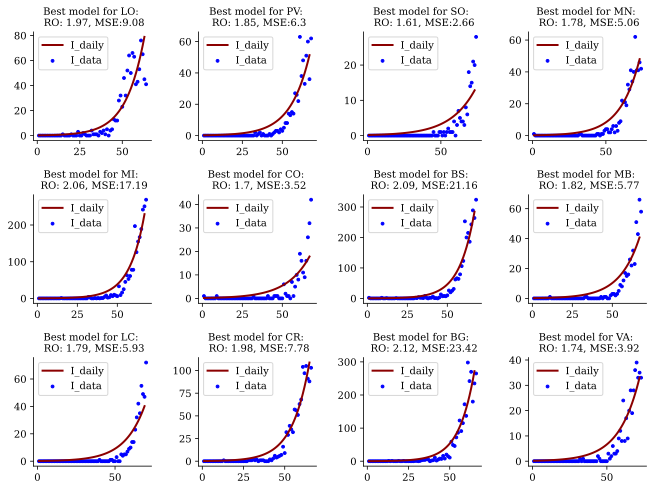

In [10]:
fig = plt.figure(figsize=(11, 8))
fig.subplots_adjust(hspace=0.5, wspace=0.4)
for i in range(len(best_model)):
    ax = fig.add_subplot(3, 4, i+1)
    ax.scatter(best_model.loc[i]['t'], df[best_model.loc[i]['region']][:len(best_model.loc[i]['t'])], 
               color = 'b', label = 'I_data', s = 8)
    ax.plot(best_model.loc[i]['t'][:-1], best_model.loc[i]['I_hat'], 
            alpha=1, lw=2, label='I_daily', color = 'darkred')
    plt.title('Best model for {}: \n RO: {}, MSE:{}'.format(best_model.loc[i]['region'], 
                                                            round(best_model.loc[i]['R0'], 2), 
                                                            round(best_model.loc[i]['MSE'],2)), size = 10)
    ax.legend(fancybox = True)
    for spine in ('top', 'right'): 
        ax.spines[spine].set_visible(False)

### Calibrating with MLE

In [11]:
from scipy.stats import poisson

def compute_loglikelihood(data, data_hat):
    llkh = 0
    for i in range(len(data)-1):
        llkh = llkh + np.log(poisson.pmf(data[i],data_hat[i]))
    return llkh

best_model_MLE = pd.DataFrame()

for row in range(len(regions_params)):

    # Initial conditions and fixed parameters
    S0 = regions_params.loc[row]['pop']-1
    I0 = 1
    R0 = 0
    y0 = S0, I0, R0
    d = 10

    # time variables: 
    ndays = regions_params.loc[row]['train_days']
    region = regions_params.loc[row]['region']
    t = np.arange(1, ndays+1, 1)
    
    R0s = np.arange(1, 3, 0.001)
    
    llkhs = []
    I_hats = []

    for R0 in R0s:  
        beta= R0*1/d 
        gamma= 1/d

        RES = odeint(SIR_eq, y0, t, args=(beta, gamma))
        S, I_hat, R = RES.T

        I_daily = I_hat[1:] + R[1:] - I_hat[:-1] - R[:-1]
        I_hats.append(I_daily)

        llkh = compute_loglikelihood(df[region][:ndays], I_daily)
        llkhs.append(llkh)

    cal = pd.DataFrame({'region': [region]*len(R0s),
                        'R0': R0s, 'llkh': llkhs, 
                        'I_hat': I_hats, 't': [t]*len(R0s)})
    best_model_MLE = best_model_MLE.append(cal.loc[cal['llkh'].idxmax()], ignore_index=True)

<ipython-input-11-17fed6c3e625>:6: RuntimeWarning: divide by zero encountered in log
  llkh = llkh + np.log(poisson.pmf(data[i],data_hat[i]))


In [12]:
best_model_MLE.head()

,I_hat,R0,llkh,region,t
0,"[0.20674997010751262, 0.22778452106655506, 0.2...",1.969,-199.447119,LO,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,"[0.19023631966986, 0.2065952025965364, 0.22436...",1.825,-178.307028,PV,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
2,"[0.1609968431495692, 0.17035229599310692, 0.18...",1.565,-114.743384,SO,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
3,"[0.1820644424063893, 0.19630167129043066, 0.21...",1.753,-184.846334,MN,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
4,"[0.21393888647350812, 0.23717307027714424, 0.2...",2.031,-375.295404,MI,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


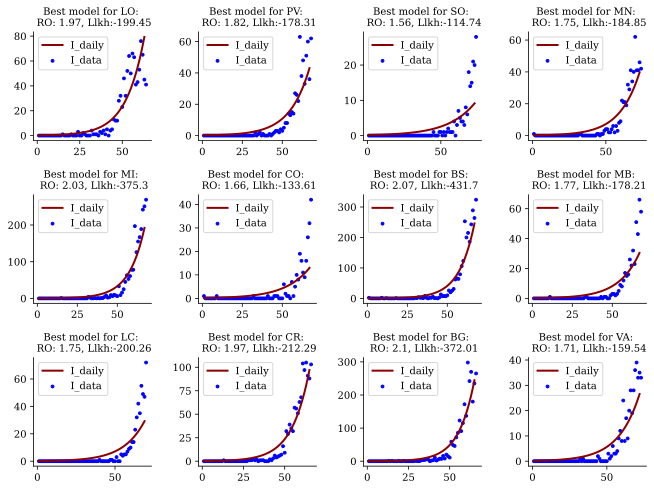

In [13]:
fig = plt.figure(figsize=(11, 8))
fig.subplots_adjust(hspace=0.5, wspace=0.4)
for i in range(len(best_model_MLE)):
    region = best_model_MLE.loc[i]['region']
    ax = fig.add_subplot(3, 4, i+1)
    ax.scatter(best_model_MLE.loc[i]['t'], df[region][:len(best_model_MLE.loc[i]['t'])], 
               color = 'b', label = 'I_data', s = 8)
    ax.plot(best_model_MLE.loc[i]['t'][:-1], best_model_MLE.loc[i]['I_hat'], 
            alpha=1, lw=2, label='I_daily', color = 'darkred')
    plt.title('Best model for {}: \n RO: {}, Llkh:{}'.format(region, 
                                                            round(best_model_MLE.loc[i]['R0'], 2), 
                                                            round(best_model_MLE.loc[i]['llkh'],2)), size = 10)
    ax.legend(fancybox = True)
    for spine in ('top', 'right'): 
        ax.spines[spine].set_visible(False)

### Calibrating with Monte-Carlo method

In [22]:
def metropolis_hastings(iterations, beta_start, gamma, std, true_data, *args):

    RES = odeint(SIR_eq, y0, t, args=(beta_start, gamma))
    S, I_hat, R = RES.T
    I_daily = I_hat[1:] + R[1:] - I_hat[:-1] - R[:-1]

    BETAS =[beta_start]
    llkh = [compute_loglikelihood(true_data, I_daily)]

    for ITER in range(iterations):

        beta_current = BETAS[-1]
        llkh_current = llkh[-1]

        beta_new = np.random.normal(beta_current, std, size = 1)
        RES = odeint(SIR_eq, y0, t, args=(beta_new, gamma))
        S, I_hat, R = RES.T
        I_daily = I_hat[1:] + R[1:] - I_hat[:-1] - R[:-1]
        llkh_new = compute_loglikelihood(true_data, I_daily)

        alpha = np.e**(llkh_new - llkh_current)

        if alpha <= np.random.uniform(0,1): 
            BETAS.append(beta_current)
            llkh.append(llkh_current)

        else: 
            BETAS.append(beta_new)
            llkh.append(llkh_new)

    BETAS = BETAS[400:] 
    llkh = llkh[400:]

    return np.array(BETAS).flatten(), np.array(llkh).flatten()

MH_betas = pd.DataFrame()

np.random.seed(6)

for row in range(len(regions_params)):
 
    # Initial conditions and fixed parameters
    S0 = regions_params.loc[row]['pop']-1
    I0 = 1
    R0 = 0
    y0 = S0, I0, R0
    d = 10

    # time variables
    ndays = regions_params.loc[row]['train_days']
    region = regions_params.loc[row]['region']
    t = np.arange(1, ndays+1, 1)

    std = 0.01
    iterations = 3000

    BETAS, llkh = metropolis_hastings(iterations, 0.15, gamma, std, df.iloc[:ndays,row])  
    betas_df = pd.DataFrame({'betas': [BETAS], 'loglikelihood': [llkh], 
                             'region':region, 'mean_beta': np.mean(BETAS)})
    MH_betas = MH_betas.append(betas_df, ignore_index=True)

<ipython-input-11-17fed6c3e625>:6: RuntimeWarning: divide by zero encountered in log
  llkh = llkh + np.log(poisson.pmf(data[i],data_hat[i]))
<ipython-input-22-d6e34982be27>:21: RuntimeWarning: overflow encountered in double_scalars
  alpha = np.e**(llkh_new - llkh_current)
<ipython-input-22-d6e34982be27>:21: RuntimeWarning: invalid value encountered in double_scalars
  alpha = np.e**(llkh_new - llkh_current)


In [23]:
MH_betas

,betas,loglikelihood,region,mean_beta
0,"[0.1963927276976116, 0.1963927276976116, 0.196...","[-199.84110323683274, -199.84110323683274, -19...",LO,0.196929
1,"[0.18209440182648834, 0.18209440182648834, 0.1...","[-178.4990549973695, -178.4990549973695, -178....",PV,0.182455
2,"[0.15449284537462077, 0.1544003518770824, 0.15...","[-116.00689677558839, -116.12546115692228, -11...",SO,0.156470
3,"[0.1746527295437286, 0.1746527295437286, 0.174...","[-185.26582044579297, -185.26582044579297, -18...",MN,0.175195
4,"[0.20370028976869564, 0.20370028976869564, 0.2...","[-376.478616903868, -376.478616903868, -376.47...",MI,0.203186
5,"[0.1645319138240954, 0.1645319138240954, 0.164...","[-134.05286703150654, -134.05286703150654, -13...",CO,0.165635
6,"[0.20713224888412046, 0.20713224888412046, 0.2...","[-431.8347039179374, -431.8347039179374, -432....",BS,0.206923
7,"[0.17690190960207455, 0.17690190960207455, 0.1...","[-178.45568018720408, -178.45568018720408, -17...",MB,0.177512
8,"[0.17586549329577428, 0.17586549329577428, 0.1...","[-200.67246137365487, -200.67246137365487, -20...",LC,0.175126
9,"[0.1966142062413167, 0.1966142062413167, 0.196...","[-212.3858767473866, -212.3858767473866, -212....",CR,0.196867


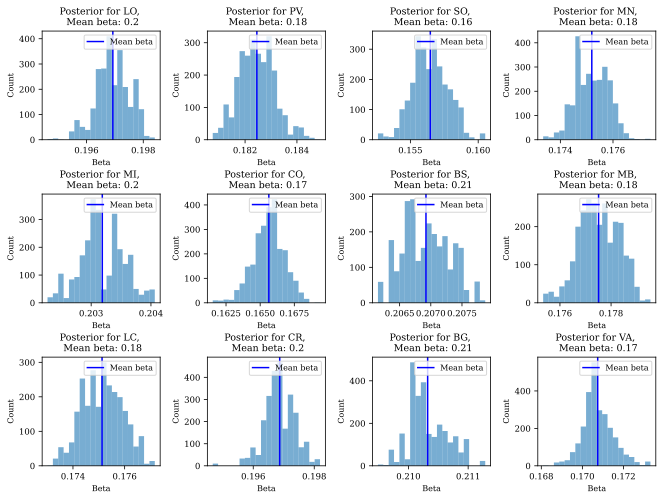

In [24]:
fig = plt.figure(figsize=(11, 8))
fig.subplots_adjust(hspace=0.5, wspace=0.4)
for i in range(len(MH_betas)):
    ax = fig.add_subplot(3, 4, i+1)
    ax.set_title('Posterior for {}, \n Mean beta: {}'.format(MH_betas.loc[i]['region'], round(MH_betas.loc[i]['mean_beta'],2)), size=9.5)
    ax.hist(MH_betas.loc[i]['betas'], bins = 20, alpha = 0.6)
    ax.axvline(MH_betas.loc[i]['mean_beta'], color='b', label='Mean beta')
    ax.set_xlabel('Beta', size=8)
    ax.set_ylabel('Count', size=8)
    ax.legend(fancybox = True, loc=1, fontsize = 8)
    plt.xticks(size=8.5)
    plt.yticks(size=8.5)

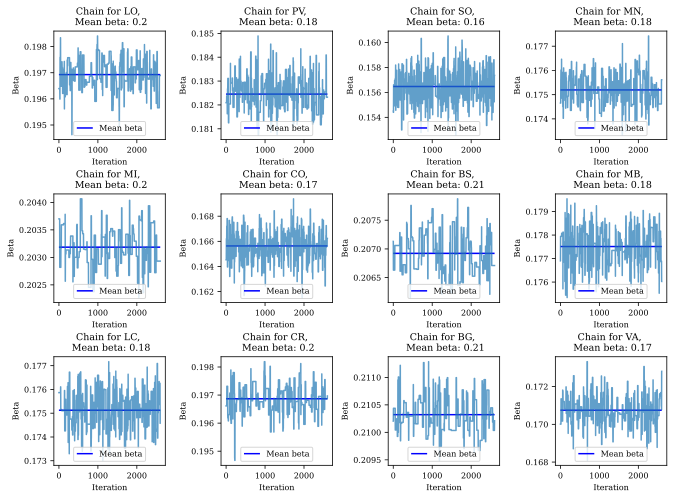

In [25]:
fig = plt.figure(figsize=(11, 8))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(len(MH_betas)):
    ax = fig.add_subplot(3, 4, i+1)
    ax.set_title('Chain for {}, \n Mean beta: {}'.format(MH_betas.loc[i]['region'], round(MH_betas.loc[i]['mean_beta'],2)), size=9.5)
    ax.plot(range(len(MH_betas.loc[i]['betas'])), MH_betas.loc[i]['betas'], alpha = 0.7)
    ax.set_xlabel('Iteration', size=8)
    ax.set_ylabel('Beta', size=8)
    ax.hlines(MH_betas.loc[i]['mean_beta'], 0, len(MH_betas.loc[i]['betas']), color='b', label='Mean beta')
    ax.legend(fancybox = True, loc=8, fontsize = 8)
    plt.xticks(size=8)
    plt.yticks(size=8)

In [26]:
best_model_MH = pd.DataFrame()

MH_R0s = round(MH_betas['mean_beta']*d,2)

for i in range(len(MH_betas)):
    
    region = MH_betas.loc[i]['region']
    
    # Initial conditions and fixed parameters
    S0 = regions_params.loc[i]['pop']-1
    I0 = 1
    R0 = 0
    y0 = S0, I0, R0
    d = 10

    # time variables: 
    ndays = regions_params.loc[i]['train_days']
    t = np.arange(1, ndays+1, 1)

    beta= MH_betas['mean_beta'][i]
    gamma= 1/d

    RES = odeint(SIR_eq, y0, t,  args=(beta, gamma))
    S, I_hat, R = RES.T

    n_cases = (I_hat[1:]+R[1:])-(I_hat[:-1]+R[:-1])
    true_I = df[region][:ndays] 

    df_MH = pd.DataFrame({'region':region,
                         'I_hat': [n_cases],
                         'true_I': [true_I],
                        'R0':MH_R0s[i],
                         't':[t]})
    best_model_MH = best_model_MH.append(df_MH, ignore_index=True)

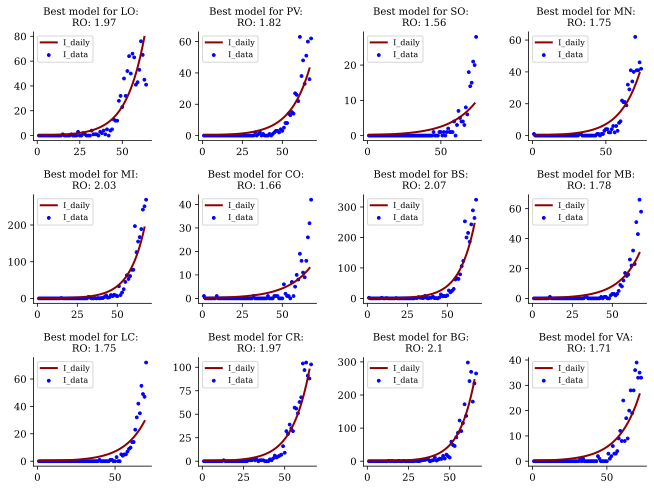

In [27]:
fig = plt.figure(figsize=(11, 8))
fig.subplots_adjust(hspace=0.5, wspace=0.4)
for i in range(len(best_model_MH)):
    region = best_model_MH.loc[i]['region']
    ax = fig.add_subplot(3, 4, i+1)
    ax.scatter(best_model_MH.loc[i]['t'], df[region][:len(best_model_MH.loc[i]['t'])], 
               color = 'b', label = 'I_data', s=8)
    ax.plot(best_model_MH.loc[i]['t'][:-1], best_model_MH.loc[i]['I_hat'], 
            alpha=1, lw=2, label='I_daily', color = 'darkred')
    plt.title('Best model for {}: \n RO: {}'.format(region,
                                                    round(best_model_MH.loc[i]['R0'], 2)), size = 10)
    ax.legend(fancybox = True, fontsize=8)
    for spine in ('top', 'right'): 
        ax.spines[spine].set_visible(False)

### Comparing R0s

As shown below, calibrated $R0$s tend to be consistent regardless of the calibration method used.

In [28]:
# best_R0s comparison
pd.DataFrame({'region':best_model['region'],
              'RMSE': round(best_model['R0'],2),
             'MLE': round(best_model['R0'],2),
             'MH': round(MH_betas['mean_beta']*d,2)})

,region,RMSE,MLE,MH
0,LO,1.97,1.97,1.97
1,PV,1.85,1.85,1.82
2,SO,1.61,1.61,1.56
3,MN,1.78,1.78,1.75
4,MI,2.06,2.06,2.03
5,CO,1.70,1.70,1.66
6,BS,2.09,2.09,2.07
7,MB,1.82,1.82,1.78
8,LC,1.79,1.79,1.75
9,CR,1.98,1.98,1.97


## SEIR model

More recent studies described COVID-19 spread where individuals are assumed to be exposed
(but noninfectious) for an average of eight days and infectious for an average of five days—leading
to SEIR-type dynamics.(Rǎdulescu et al., 2020)

<div class="alert alert-block alert-success">

Individuals belong one of those categories. (1) Susceptibles ($S$); (2) Exposed ($E$); (3) Infected ($I$); (4) Recovered/immune ($R$).
System of differential equations :

\begin{eqnarray}
\frac{\partial S_t}{\partial t} = -\beta S_t I_t\\
\frac{\partial E_t}{\partial t} = \beta S_t I_t\ - \sigma E_t\\
\frac{\partial I_t}{\partial t} = \sigma E_t - \gamma I_t\\
\frac{\partial R_t}{\partial t} = \gamma I_t\\
\end{eqnarray}

**Parameters:**
1. $\beta$: transmission probability
2. $\sigma$: incubation rate (1/$\sigma$ is the mean incubation period)
3. $\gamma$: the recovery rate :  (1/$\gamma$ is the average duration of recovery or average infectious period)



In [29]:
def SEIR_eq(INPUT, t,  beta, sigma, gamma):
    
    S, E, I, R = INPUT
    N = S + E + I + R
    
    dS_dt = -beta*S*I/N
    dE_dt = beta*S*I/N - sigma*E
    dI_dt = sigma*E - gamma*I
    dR_dt = gamma*I
    
    return dS_dt, dE_dt, dI_dt, dR_dt

The SEIR model was first run with fixed sigma to calibrate $R0$ using RMSE method.

### Calibrating R0 using SEIR with RMSE

In [43]:
best_SEIR_RMSE = pd.DataFrame()

df_R_d_full = pd.DataFrame()

for row in range(len(regions_params)):
    
    # Initial conditions and fixed parameters
    region = regions_params.loc[row]['region']
    S0 = regions_params.loc[row]['pop']-1
    E0 = 0
    I0 = 1
    R0 = 0
    y0 = S0, E0, I0, R0
    d = 10

    # time variables: 
    ndays = regions_params.loc[row]['train_days']
    t = np.arange(1, ndays+1, 1)

    R0s = np.arange(1, 3, 0.001)
    MSEs = []  
    I_hats = []

    df_R_d_full = pd.DataFrame()
    
    for R0 in R0s:
        
        beta= R0*1/d 
        gamma= 1/d
        sigma=1/5.2 # Li, Qun et al. (2020) 5.2 is the average time for an exposed individual to become infectious.

        RES = odeint(SEIR_eq, y0, t,  args=(beta, sigma, gamma))
        S, E, I_hat, R = RES.T

        n_cases = I_hat[1:] + R[1:] - I_hat[:-1] - R[:-1]
        true_I = df[region][:len(n_cases)]

        I_hats.append(n_cases)

        MSE = np.sqrt(sum((true_I - n_cases)**2)/len(true_I))
        MSEs.append(MSE)

        df_R_d = pd.DataFrame({'region': region,'R0': R0, 'MSE': MSE, 
                               'I_hat': [n_cases], 't': [t]})

        df_R_d_full=df_R_d_full.append(df_R_d, ignore_index=True)

            
    best_SEIR_RMSE = best_SEIR_RMSE.append(df_R_d_full.loc[df_R_d_full['MSE'].idxmin()], ignore_index=True)

In [44]:
best_SEIR_RMSE

,I_hat,MSE,R0,region,t
0,"[0.026302497362610255, 0.07068266173763353, 0....",12.192158,2.999,LO,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,"[0.025034127578666743, 0.06721358733701326, 0....",6.010140,2.855,PV,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
2,"[0.019920733262163814, 0.053289986018548174, 0...",2.459501,2.274,SO,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
3,"[0.023334564074466657, 0.06257465618720098, 0....",4.661893,2.662,MN,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
4,"[0.02630312250848421, 0.07068457605336434, 0.1...",43.760623,2.999,MI,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
5,"[0.02191793832039135, 0.058716537540036876, 0....",3.292930,2.501,CO,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
6,"[0.026302995368454818, 0.07068418672541586, 0....",59.361610,2.999,BS,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
7,"[0.024347358729333912, 0.06533780060393214, 0....",5.266422,2.777,MB,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
8,"[0.023827534991933907, 0.06391905698704223, 0....",5.409388,2.718,LC,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
9,"[0.026302742395541534, 0.07068341207370209, 0....",14.857329,2.999,CR,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."


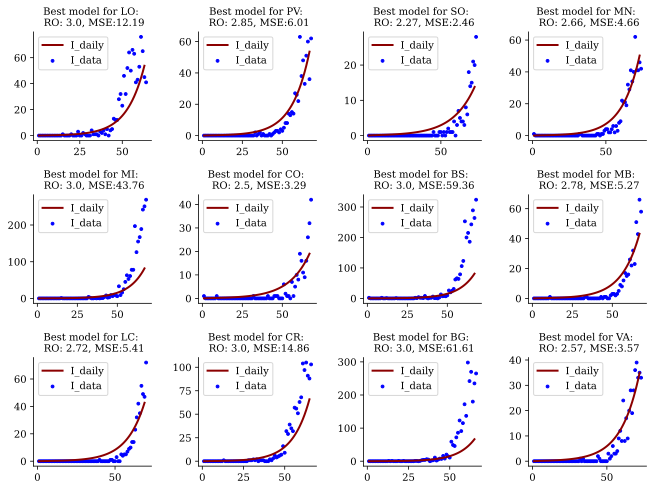

In [48]:
fig = plt.figure(figsize=(11, 8))
fig.subplots_adjust(hspace=0.5, wspace=0.4)
for i in range(len(best_SEIR_RMSE)):
    ax = fig.add_subplot(3, 4, i+1)
    ax.scatter(best_SEIR_RMSE.loc[i]['t'], df[best_SEIR_RMSE.loc[i]['region']][:len(best_SEIR_RMSE.loc[i]['t'])], 
               color = 'b', label = 'I_data', s = 8)
    ax.plot(best_SEIR_RMSE.loc[i]['t'][:-1], best_SEIR_RMSE.loc[i]['I_hat'], 
            alpha=1, lw=2, label='I_daily', color = 'darkred')
    plt.title('Best model for {}: \n RO: {}, MSE:{}'.format(best_SEIR_RMSE.loc[i]['region'], 
                                                            round(best_SEIR_RMSE.loc[i]['R0'], 2), 
                                                            round(best_SEIR_RMSE.loc[i]['MSE'],2)), size = 10)
    ax.legend(fancybox = True)
    for spine in ('top', 'right'): 
        ax.spines[spine].set_visible(False)

Next, we run SEIR model **calibrating both sigma and R0**.

In [ ]:
best_SEIR_RMSE = pd.DataFrame()

df_R_d_full = pd.DataFrame()

for row in range(len(regions_params)):
    
    # Initial conditions and fixed parameters
    region = regions_params.loc[row]['region']
    S0 = regions_params.loc[row]['pop']-1
    E0 = 0
    I0 = 1
    R0 = 0
    y0 = S0, E0, I0, R0
    d = 10

    # time variables
    ndays = regions_params.loc[row]['train_days']
    t = np.arange(1, ndays+1, 1)

    R0s = np.arange(1, 3, 0.01)
    MSEs = []  
    I_hats = []

    df_R_d_full = pd.DataFrame()
    
    for R0 in R0s:
        
        for s in np.arange(3,10,0.5):

            beta= R0*1/d 
            gamma= 1/d
            sigma=1/s # Li, Qun et al. (2020) 5.2 is the average time for an exposed individual to become infectious.

            RES = odeint(SEIR_eq, y0, t,  args=(beta, sigma, gamma))
            S, E, I_hat, R = RES.T

            n_cases = I_hat[1:] + R[1:] - I_hat[:-1] - R[:-1]
            true_I = df[region][:len(n_cases)]

            I_hats.append(n_cases)

            MSE = np.sqrt(sum((true_I - n_cases)**2)/len(true_I))
            MSEs.append(MSE)

            df_R_d = pd.DataFrame({'region': region,'R0': R0, 'MSE': MSE, 
                                   'I_hat': [n_cases], 't': [t], 'sigma': s})

            df_R_d_full=df_R_d_full.append(df_R_d, ignore_index=True)
            
    best_SEIR_RMSE = best_SEIR_RMSE.append(df_R_d_full.loc[df_R_d_full['MSE'].idxmin()], ignore_index=True)

In [ ]:
best_SEIR_RMSE

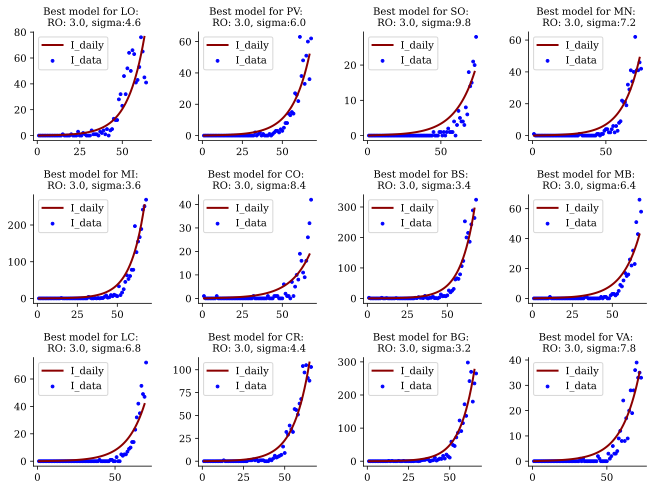

In [42]:
fig = plt.figure(figsize=(11, 8))
fig.subplots_adjust(hspace=0.5, wspace=0.4)
for i in range(len(best_SEIR_RMSE)):
    ax = fig.add_subplot(3, 4, i+1)
    ax.scatter(best_SEIR_RMSE.loc[i]['t'], df[best_SEIR_RMSE.loc[i]['region']][:len(best_SEIR_RMSE.loc[i]['t'])], 
               color = 'b', label = 'I_data', s = 8)
    ax.plot(best_SEIR_RMSE.loc[i]['t'][:-1], best_SEIR_RMSE.loc[i]['I_hat'], 
            alpha=1, lw=2, label='I_daily', color = 'darkred')
    plt.title('Best model for {}: \n RO: {}, sigma:{}'.format(best_SEIR_RMSE.loc[i]['region'], 
                                                            round(best_SEIR_RMSE.loc[i]['R0'], 2), 
                                                            round(best_SEIR_RMSE.loc[i]['sigma'],2)), size = 10)
    ax.legend(fancybox = True)
    for spine in ('top', 'right'): 
        ax.spines[spine].set_visible(False)

# Adding age structure to the model

In this section we focus on Milan province and build a simple SIR model with age structure, where transmission process depends on the interaction patterns commonly represented by WAIFW matrix. The elements of this matrix are defined as  $q$ $C_ij$ where $C$ is the mixing matrix and $q$ is the infection-specific parameter. We use RMSE and MLE techniques to calibrate $q$ and calculate $R0$ for the age-stratified model which is defined as: 

$R0$ = $q$ $\rho$$(C)$, where $\rho$$(C)$ is the spectral radius of matrix $C$

The number of initial susceptible population was assumed to be 1,406,241 and data for the population age structure was adopted from ISTAT. We put the first infected person into an arbitrary age group (people from 30 to 34). RMSE gives an estimated $q$ of 0.176 and corresponding $R0$ is 2.052. With MLE method the best $q$ is 0.17 with the corresponding $R0$ of 2.017. <br/>
People between 40 to 59 were the most infected groups as they had the highest number of new cases in Milan (most of them were teachers and workers and their social interaction were higher than other age groups) and among them, people between 50-54 were slightly higher than the rest.

In [ ]:
c = pd.read_csv('italian_matrix.csv').drop('Unnamed: 0', axis=1)

In [52]:
age_dist = pd.read_excel('age_distribution_MI.xlsx', header = None)
age_dist.columns = ['age', 'num']

age_distrib = {}
for i in np.arange(0,71,5):
    k = i+5
    age_distrib['{}-{}'.format(i,k-1)] = np.sum(age_dist['num'][i:k])

age_distrib['75+'] = np.sum(age_dist['num'][75:-1])

age_dist = pd.DataFrame({'age':age_distrib.keys(),
             'num':age_distrib.values()})

total = np.sum(age_dist['num'])
age_dist['share'] = round(age_dist['num']/total,5)

<div class="alert alert-block alert-success">

**System of differential equations** :

\begin{eqnarray}
\frac{\partial S_{i}}{\partial t} = -\sum_j{\beta_{ij}I_jS_i} \\
\frac{\partial I_{i}}{\partial t} = \sum_j{\beta_{ij}I_jS_i} - \gamma I_i \\
\frac{\partial R_{i}}{\partial t} = \gamma I_i \\
\end{eqnarray}

In [53]:
def SIR_age_eq(INPUT, t, BETA, gamma):

    Y = np.zeros((48))
    V = INPUT
    k = 16
    for i in range(k):
        SUM = np.dot(BETA[i], V[k:k*2]) * V[i]
        Y[i] = - SUM
        Y[(k+i)] = SUM - gamma  * V[(k+i)]
        Y[(2*k+i)] = gamma  * V[(k+i)]
    return Y

### Calibrating q with RMSE

In [54]:
# INITIALIZE POPULATION
N = 1406242
n = np.array(age_dist['share']) # Proportion of the population in each class
S = (N - 1) * n 
I = np.zeros(len(n))
I[6] = 1 # let the infection start in group 7 
R = np.zeros(len(n))

INPUT = np.hstack((S,I,R))/N

# time period
ndays = int(regions_params[regions_params.region == 'MI']['train_days'])
t = np.arange(1, ndays+1, 1)

# other params
d = 10
gamma = 1/d
MSEs = []  
I_hats = []

Qs = np.arange(0,1,0.001)

for q in Qs:
    
    BETA = c.to_numpy()*q

    RES = odeint(SIR_age_eq, INPUT, t,  args=(BETA, gamma))
    
    S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15,S16,\
    I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13,I14,I15,I16,\
    R1,R2,R3,R4,R5,R6,R7,R8,R9,R10,R11,R12,R13,R14,R15,R16 = RES.T
    
    total_I = (I1+I2+I3+I4+I5+I6+I7+I8+I9+I10+I11+I12+I13+I14+I15+I16)*N
    total_R = (R1+R2+R3+R4+R5+R6+R7+R8+R9+R10+R11+R12+R13+R14+R15+R16)*N
    n_cases = total_I[1:]+ total_R[1:] - total_I[:-1] - total_R[:-1]
    true_I = df['MI'][:len(n_cases)]

    I_hats.append(n_cases)

    MSE = np.sqrt(sum((true_I - n_cases)**2)/len(true_I))
    MSEs.append(MSE)

calibration = pd.DataFrame({'region': ['MI']*len(Qs),
                    'Qs': Qs, 'MSE': MSEs, 'I_hat': I_hats, 't': [t]*len(Qs)})
best_q = calibration.loc[calibration['MSE'].idxmin()]

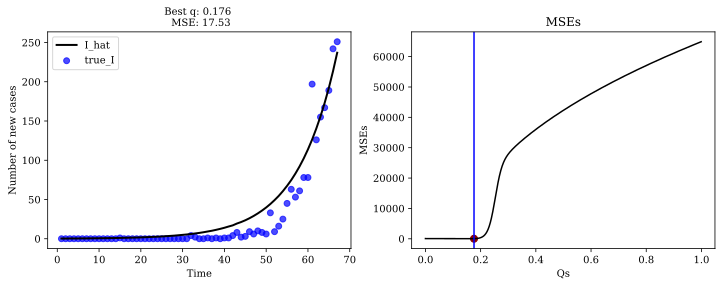

In [55]:
fig, axs = plt.subplots(1,2, facecolor='w', figsize=(12,4))

ax = axs[0]
ax.plot(t[:-1], best_q['I_hat'], label='I_hat', color='black', lw=2)
ax.scatter(t[:-1], true_I, label='true_I', color='b', alpha=0.7)
ax.legend(loc='upper left')
ax.set_title('Best q: {} \n MSE: {}'.format(best_q.Qs, round(best_q.MSE, 2)), size=10)
ax.set_xlabel('Time')
ax.set_ylabel('Number of new cases')

ax = axs[1]
ax.set_title('MSEs')
ax.plot(calibration['Qs'], calibration['MSE'], color = 'k')
ax.scatter(best_q.Qs, best_q.MSE, color = 'darkred' , s = 50, label='max log-lkh' )
ax.axvline(x = best_q.Qs, ymin=0, ymax=20, c= 'b')
ax.set_xlabel('Qs')
ax.set_ylabel('MSEs')

plt.show()

#### Calculating R0

In [58]:
max_eigen = max(np.real(np.linalg.eigvals(c*n)))
cal_R0 = best_q['Qs']*max_eigen/gamma
print('Estimated R0: ', cal_R0)

Estimated R0:  2.0527516680371223


### Calibrating q with MLE

In [57]:
def compute_loglikelihood(data, data_hat):
    llkh = 0
    for i in range(len(data)-1):
        llkh = llkh + np.log(poisson.pmf(data[i],data_hat[i]))
    return llkh

# INITIALIZE POPULATION
N = 1406242
n = np.array(age_dist['share']) # Proportion of the population in each class
S = (N - 1) * n 
I = np.zeros(len(n))
I[6] = 1 # let the infection start in group 7 
R = np.zeros(len(n))

INPUT = np.hstack((S,I,R))/N

# time period
ndays = int(regions_params[regions_params.region == 'MI']['train_days'])
t = np.arange(1, ndays+1, 1)

# other params
d = 10
gamma = 1/d
llkhs = []  
I_hats = []

Qs = np.arange(0,1,0.001)

for q in Qs:
    
    BETA = c.to_numpy()*q

    RES = odeint(SIR_age_eq, INPUT, t,  args=(BETA, gamma))
    
    S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15,S16,\
    I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13,I14,I15,I16,\
    R1,R2,R3,R4,R5,R6,R7,R8,R9,R10,R11,R12,R13,R14,R15,R16 = RES.T
    
    total_I = (I1+I2+I3+I4+I5+I6+I7+I8+I9+I10+I11+I12+I13+I14+I15+I16)*N
    total_R = (R1+R2+R3+R4+R5+R6+R7+R8+R9+R10+R11+R12+R13+R14+R15+R16)*N
    n_cases = total_I[1:]+ total_R[1:] - total_I[:-1] - total_R[:-1]
    true_I = df['MI'][:len(n_cases)]

    I_hats.append(n_cases)

    llkh = compute_loglikelihood(true_I, n_cases)
    llkhs.append(llkh)

calibration = pd.DataFrame({'region': ['MI']*len(Qs),
                    'Qs': Qs, 'llkh': llkhs, 'I_hat': I_hats, 't': [t]*len(Qs)})
best_q_MLE = calibration.loc[calibration['llkh'].idxmax()]

<ipython-input-57-672f6e679ccb>:4: RuntimeWarning: divide by zero encountered in log
  llkh = llkh + np.log(poisson.pmf(data[i],data_hat[i]))


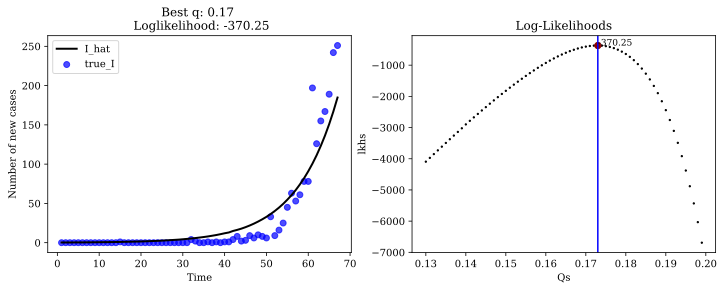

In [59]:
fig, axs = plt.subplots(1,2, facecolor='w', figsize=(12,4))

ax = axs[0]
ax.plot(t[:-1], best_q_MLE['I_hat'], label='I_hat', color='black', lw=2)
ax.scatter(t[:-1], true_I, label='true_I', color='b', alpha=0.7)
ax.legend(loc='upper left')
ax.set_title('Best q: {} \n Loglikelihood: {}'.format(round(best_q_MLE['Qs'],2),round(best_q_MLE['llkh'], 2),size=10))
ax.set_xlabel('Time')
ax.set_ylabel('Number of new cases')

ax = axs[1]
ax.set_title('Log-Likelihoods')
ax.scatter(calibration['Qs'], calibration['llkh'], color = 'k' , s =2 )
ax.scatter(best_q_MLE['Qs'], best_q_MLE['llkh'], color = 'darkred' , s = 40, label='max log-lkh' )
ax.axvline(x = best_q_MLE['Qs'], ymin=0, ymax=20, c= 'b')
ax.annotate('{}'.format(round(best_q_MLE['llkh'],2)), (best_q_MLE['Qs'], best_q_MLE['llkh']), size=9, 
            xytext=(best_q_MLE['Qs'], best_q_MLE['llkh']))
ax.set_xlabel('Qs')
ax.set_ylabel('lkhs')

plt.show()

#### Calculating R0

In [60]:
max_eigen = max(np.real(np.linalg.eigvals(c*n)))
cal_R0 = best_q_MLE['Qs']*max_eigen/gamma
print('Estimated R0: ', cal_R0)

Estimated R0:  2.0177615827864894


### What age groups were infected the most?

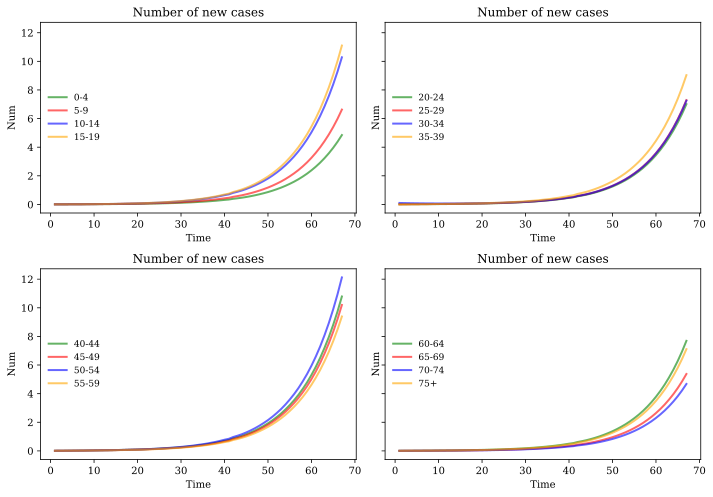

In [61]:
N = 1406242
n = np.array(age_dist['share']) 
S = (N - 1) * n 
I = np.zeros(len(n))
I[6] = 1
R = np.zeros(len(n))

INPUT = np.hstack((S,I,R))/N

# time period
ndays = int(regions_params[regions_params.region == 'MI']['train_days'])
# ndays = len(df['MI'])
t = np.arange(1, ndays+1, 1)
gamma = 1/10

q_MLE = best_q_MLE['Qs']
BETA = c.to_numpy()*q_MLE

RES = odeint(SIR_age_eq, INPUT, t,  args=(BETA, gamma))

S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15,S16,\
I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13,I14,I15,I16,\
R1,R2,R3,R4,R5,R6,R7,R8,R9,R10,R11,R12,R13,R14,R15,R16 = RES.T

n_cases = total_I[1:]+ total_R[1:] - total_I[:-1] - total_R[:-1]

#PLOTS
fig, axs = plt.subplots(nrows=2, ncols=2, facecolor='w', figsize=(10,7), sharey='all')

age_groups = np.array([age for age in list(age_dist['age'])])

Susceptibles = [num*N for num in [S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15,S16]]
Infected = [num*N for num in [I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13,I14,I15,I16]]
Recovered = [num*N for num in [R1,R2,R3,R4,R5,R6,R7,R8,R9,R10,R11,R12,R13,R14,R15,R16]]

n_cases_I_R = [group_I[1:] + group_R[1:] - group_I[:-1] - group_R[:-1] for group_I in Infected for group_R in Recovered]

for row in range(2):
    for col in range(2):
        ax = axs[row,col]
        total_I_share = round(Infected[row+col][-1]*100/np.array(N*n)[row+col],2)
        ax.set_title('Number of new cases', size=12)
        if row == 0:
            ax.plot(t[:-1], n_cases_I_R[(row+col)*4], 'g', alpha=0.6, lw=2, label=age_groups[(row+col)*4])
            ax.plot(t[:-1], n_cases_I_R[(row+col)*4+1], 'r', alpha=0.6, lw=2, label=age_groups[(row+col)*4+1])
            ax.plot(t[:-1], n_cases_I_R[(row+col)*4+2], 'b', alpha=0.6, lw=2, label=age_groups[(row+col)*4+2])
            ax.plot(t[:-1], n_cases_I_R[(row+col)*4+3], 'orange', alpha=0.6, lw=2, label=age_groups[(row+col)*4+3])
        else:
            ax.plot(t[:-1], n_cases_I_R[(row+col)*4+4], 'g', alpha=0.6, lw=2, label=age_groups[(row+col)*4+4])
            ax.plot(t[:-1], n_cases_I_R[(row+col)*4+5], 'r', alpha=0.6, lw=2, label=age_groups[(row+col)*4+5])
            ax.plot(t[:-1], n_cases_I_R[(row+col)*4+6], 'b', alpha=0.6, lw=2, label=age_groups[(row+col)*4+6])
            ax.plot(t[:-1], n_cases_I_R[(row+col)*4+7], 'orange', alpha=0.6, lw=2, label=age_groups[(row+col)*4+7])
        ax.set_xlabel('Time', fontsize=10)
        ax.set_ylabel('Num', fontsize=10)
        ax.legend(loc="center left", fontsize=9, frameon=False) # upper left corner
        fig.tight_layout()
plt.show()

# Implement restrictions in the model

After building an age-structured model in Milan, we introduce restrictive social-distancing measures among different groups. <br/>

First, **at day 65** we assume the closure of schools and universities which results in reduced interaction among pupils, students, teachers and professors. In the model this is done by changing the corresponding elements of the mixing matrix $C$. Then, starting **from day 70 we introduce restrictive measures for all age groups**, which includes border closures, restricted movement, closures of cafés, restaurants and other public places. At the meantime we assume that these changes are not abrupt, but implemented gradually, therefore $C$ matrix is changed **every 3 days**. This also allows to control for non-perfect compliance with the restrictive measures that we have seen in
reality.<br/>

Introduction of restrictive measures allows to reduce the spread of the infection and finally combat the virus.

In [268]:
def SIR_age_restr(INPUT, t, c0, c1, q, gamma):

    Y = np.zeros((48))
    V = INPUT
    k = 16
    if t <= 65:
        BETA_0 = c0.to_numpy()*q
        for i in range(k):
            SUM = np.dot(BETA_0[i], V[k:k*2]) * V[i]
            Y[i] = - SUM
            Y[(k+i)] = SUM - gamma  * V[(k+i)]
            Y[(2*k+i)] = gamma  * V[(k+i)]
            
    if (t > 65)*(t<=70):
        BETA_0 = c1.to_numpy()*q
        for i in range(k):
            SUM = np.dot(BETA_0[i], V[k:k*2]) * V[i]
            Y[i] = - SUM
            Y[(k+i)] = SUM - gamma  * V[(k+i)]
            Y[(2*k+i)] = gamma  * V[(k+i)]
    if t==66:
        max_eigen = max(np.real(np.linalg.eigvals(c1*n)))
        cal_R0 = best_q_MLE['Qs']*max_eigen/gamma
        print('Estimated R0 at time {}: ', cal_R0, t)
            
    if t > 70:
        if t%3==3:
            BETA_0 = c1.to_numpy()*q*0.85**((22-(92-t))//3)
            max_eigen = max(np.real(np.linalg.eigvals(BETA_0*n/q)))
            cal_R0 = best_q_MLE['Qs']*max_eigen/gamma
            print('Estimated R0 at time {}: ', cal_R0, t)
        else:
            BETA_0 = c1.to_numpy()*q*0.85**((22-(92-t-1))//3)
        for i in range(k):
            SUM = np.dot(BETA_0[i], V[k:k*2]) * V[i]
            Y[i] = - SUM
            Y[(k+i)] = SUM - gamma  * V[(k+i)]
            Y[(2*k+i)] = gamma  * V[(k+i)]
    
    return Y

In [270]:
c_0 = c.copy()
c_1 = c.copy()
c_1.iloc[0,0] = c_1.iloc[0,0]*0.2 # less children-children interaction
c_1.iloc[1,1:3] = c_1.iloc[1,1:3]*0.2 # less children-children interaction
c_1.iloc[1,8:11] = c_1.iloc[1,8:11]*0.5 # less children-nurse interaction
c_1.iloc[2,1:4] = c_1.iloc[2,1:4]*0.2 # less children-children interaction because of closed schools
c_1.iloc[2,8:11] = c_1.iloc[2,8:11]*0.5 # less children-teacher interaction
c_1.iloc[3,3] = c_1.iloc[3,3]*0.2 # less pupil-pupil interaction
c_1.iloc[3,8:11] = c_1.iloc[3,8:11]*0.5 # less pupil-teacher interaction
c_1.iloc[4,4:6] = c_1.iloc[4,4:6]*0.2 # less student-student interaction
c_1.iloc[4,9:13] = c_1.iloc[4,9:13]*0.5 # less student-professor interaction

In [266]:
N = 1406242
n = np.array(age_dist['share']) 
S = (N - 1) * n 
I = np.zeros(len(n))
I[6] = 1 
R = np.zeros(len(n))

INPUT = np.hstack((S,I,R))/N

# time period
ndays = len(df['MI'])
t = np.arange(1, ndays+1, 1)
gamma = 1/10

q_MLE = best_q_MLE['Qs']

RES = odeint(SIR_age_restr, INPUT, t,  args=(c_0,c_1, q_MLE, gamma))

S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15,S16,\
I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13,I14,I15,I16,\
R1,R2,R3,R4,R5,R6,R7,R8,R9,R10,R11,R12,R13,R14,R15,R16 = RES.T

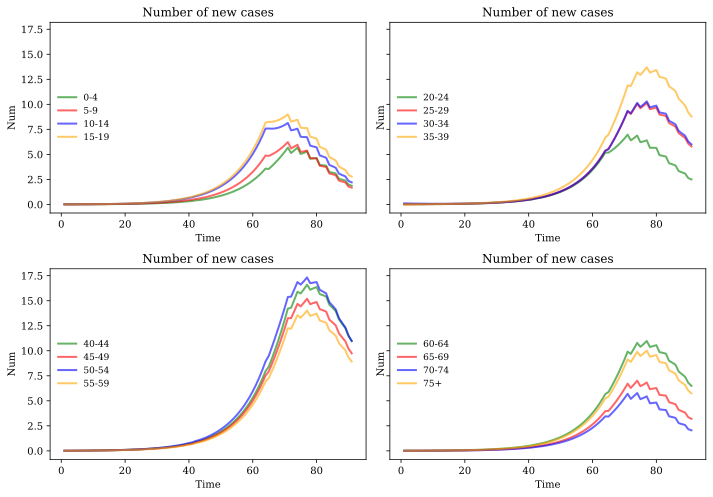

In [267]:

#PLOTS
fig, axs = plt.subplots(nrows=2, ncols=2, facecolor='w', figsize=(10,7), sharey='all')

age_groups = np.array([age for age in list(age_dist['age'])])

Susceptibles = [num*N for i,num in enumerate([S1,S2,S3,S4,S5,S6,S7,S8,S9,S10,S11,S12,S13,S14,S15,S16])]
Infected = [num*N for i,num in enumerate([I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13,I14,I15,I16])]
Recovered = [num*N for i,num in enumerate([R1,R2,R3,R4,R5,R6,R7,R8,R9,R10,R11,R12,R13,R14,R15,R16])]

n_cases_I_R = [group_I[1:] + group_R[1:] - group_I[:-1] - group_R[:-1] for group_I in Infected for group_R in Recovered]

for row in range(2):
    for col in range(2):
        ax = axs[row,col]
        total_I_share = round(Infected[row+col][-1]*100/np.array(N*n)[row+col],2)
        ax.set_title('Number of new cases', size=12)
        if row == 0:
            ax.plot(t[:-1], n_cases_I_R[(row+col)*4], 'g', alpha=0.6, lw=2, label=age_groups[(row+col)*4])
            ax.plot(t[:-1], n_cases_I_R[(row+col)*4+1], 'r', alpha=0.6, lw=2, label=age_groups[(row+col)*4+1])
            ax.plot(t[:-1], n_cases_I_R[(row+col)*4+2], 'b', alpha=0.6, lw=2, label=age_groups[(row+col)*4+2])
            ax.plot(t[:-1], n_cases_I_R[(row+col)*4+3], 'orange', alpha=0.6, lw=2, label=age_groups[(row+col)*4+3])
        else:
            ax.plot(t[:-1], n_cases_I_R[(row+col)*4+4], 'g', alpha=0.6, lw=2, label=age_groups[(row+col)*4+4])
            ax.plot(t[:-1], n_cases_I_R[(row+col)*4+5], 'r', alpha=0.6, lw=2, label=age_groups[(row+col)*4+5])
            ax.plot(t[:-1], n_cases_I_R[(row+col)*4+6], 'b', alpha=0.6, lw=2, label=age_groups[(row+col)*4+6])
            ax.plot(t[:-1], n_cases_I_R[(row+col)*4+7], 'orange', alpha=0.6, lw=2, label=age_groups[(row+col)*4+7])
        ax.set_xlabel('Time', fontsize=10)
        ax.set_ylabel('Num', fontsize=10)
        ax.legend(loc="center left", fontsize=9, frameon=False) # upper left corner
        fig.tight_layout()
plt.show()

Text(0, 0.5, 'Number of new cases')

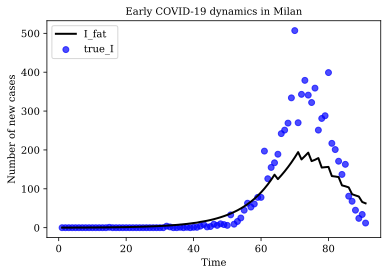

In [272]:
total_Infected = np.array(Infected).sum(axis=0)
total_Recovered = np.array(Recovered).sum(axis=0)
total_Susceptibles = np.array(Susceptibles).sum(axis=0)

n_cases = total_Infected[1:]+ total_Recovered[1:] - total_Infected[:-1] - total_Recovered[:-1]

plt.plot(t[:-1], n_cases, label='I_fat', color='black', lw=2)
plt.scatter(t[:-1], df['MI'][:-1], label='true_I', color='b', alpha=0.7)
plt.legend(loc='upper left')
plt.title('Early COVID-19 dynamics in Milan',size=10)
plt.xlabel('Time')
plt.ylabel('Number of new cases')